This noteboook defines and trains a neural-network (NN) model to fit the ice velocities values. 

The input of the model are : 
 - the two-dimensional wind velocity in EASE grid-coordinates, <b> u_ERA5,v_ERA5 </b>
 - the x and y EASE positions in EASE grid-coordinates, <b> x_EASE,y_EASE</b> 
 - the sea-ice concentration in percentage, <b>sic_CDR</b>
 - the sea-ice thickness in m, <b>h_piomas</b>
 - the day of the year ranging from 1 to 364, <b>doy</b>
 - the year, <b>year</b>
 - the distance to coast in m, <b>d2c</b>

The output of the models are:
 - the two-dimensional ice velocities in EASE grid-coordinates, <b>u_buoy,v_buoy</b>

## Import modules

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle

## Prepare the data

In [12]:
# Load the training data set
namefile = "DRIFT_DATA_TRAIN.csv"
df = pd.read_csv(namefile)

In [13]:
df.head(5)

,year,month,day,doy,x_EASE,y_EASE,u_buoy,v_buoy,id_buoy,u_ERA5,v_ERA5,sic_CDR,h_cs2smos,h_piomas,d2c
0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,-6.704156,-0.321260,0.990195,NaN,3.189743,522.523298
1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,-6.818630,-0.674205,0.966372,NaN,2.484009,412.767669
2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,-8.825469,1.123955,0.996022,NaN,2.474106,362.547379
3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,-1.079951,-1.035410,0.982681,NaN,3.740522,381.025629
4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,-2.169171,2.537787,0.990302,NaN,3.188522,521.535334


In [14]:
# Preparing the model features
# model with 9 inputs  : "u_ERA5","v_ERA5","x_EASE","y_EASE","sic_CDR","h_piomas","year","doy","d2c"
#            2 outputs : "u_buoy","v_buoy"
x = np.array(df[["u_ERA5","v_ERA5","x_EASE","y_EASE","sic_CDR","h_piomas","year","doy","d2c"]])
y = np.array(df[["u_buoy","v_buoy"]])

# Shuffle the data and divide them in train / test (using 80% / 20% distribution)
x, y = shuffle(x, y)
x_train = x[:271600]
y_train = y[:271600]
x_test = x[271600:]
y_test = y[271600:]

# Rescale the input features using the full dataset ( !!!! mean and variances need to be kept for predictions !!!! )
mean_x = np.mean(x,axis=0)
variances_x = np.var(x,axis=0)
x_train_norm = (x_train - mean_x)/variances_x
x_train_norm = x_train
x_test_norm = (x_test - mean_x)/variances_x
x_test_norm = x_test

## NN model definition

In [15]:
# Definition of the architecture of the NN
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,input_shape=[9],activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(32,activation="relu"),
    tf.keras.layers.Dense(16,activation="relu"),
    tf.keras.layers.Dense(2)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 12,178
Trainable params: 12,178
Non-trainable params: 0
_________________________________________________________________


## Running the model

In [16]:
# Run the model, need to specifiy what is the optimizer used
model.compile(loss="mse", optimizer='adam')
logs_model = model.fit(x=x_train_norm,y=y_train, epochs=1,verbose=1)

8488/8488 [==============================] - 14s 2ms/step - loss: 41.8897


In [40]:
# Save the model for future uses !
model.save('model_2.h5')

## Predicting the MSE

In [17]:
# Compute predictions from the model both on train and test sets
y_predict_train = model.predict(x_train_norm)
y_predict_test = model.predict(x_test_norm)

print("The MSE on the train data set is equal to : ",mse(y_predict_train,y_train))
print("The MSE on the test data set is equal to : ",mse(y_predict_test,y_test))

The MSE on the train data set is equal to :  24.85750719376027
The MSE on the test data set is equal to :  24.9360258040664


## Visual inspections of predictions on test set

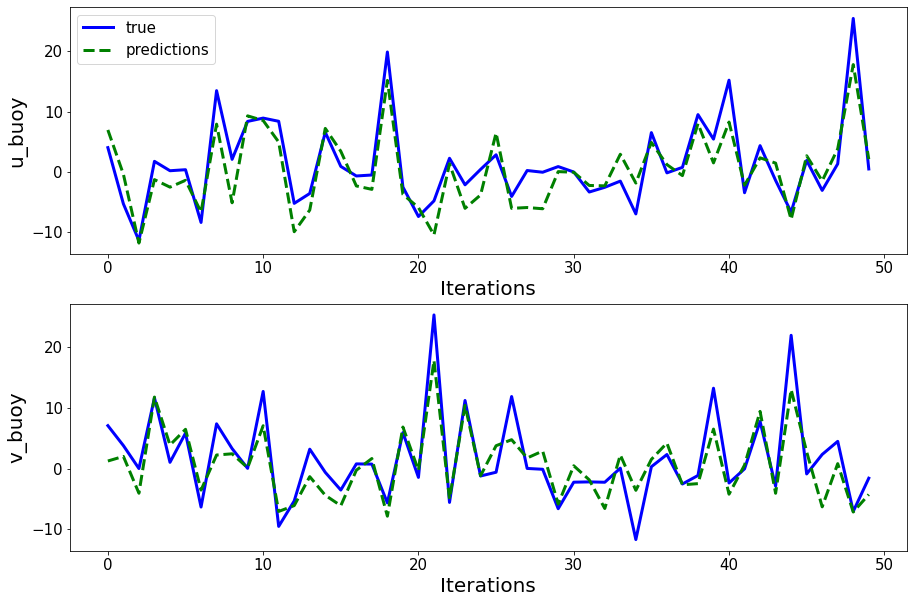

In [43]:
# Select the interval of poitns that you want to inspect (between 50 - 100 recommended)
beg = 0
end = 50

# Create matplotlib figure
fig, axes = plt.subplots(2, 1)

# Figure for u_buoy predictions
axes[0].plot(y_test.T[0][beg:end],linewidth = 3,label="true",color="b")
axes[0].plot(y_predict_test.T[0][beg:end],linewidth = 3,linestyle='dashed',label="predictions",color="g")
axes[0].legend(fontsize=15)
axes[0].set_xlabel("Iterations",fontsize=20)
axes[0].set_ylabel("u_buoy",fontsize=20)
axes[0].tick_params(labelsize=15)

# Figure for v_buoy predictions
axes[1].plot(y_test.T[1][beg:end],linewidth = 3,label="true",color="b")
axes[1].plot(y_predict_test.T[1][beg:end],linewidth = 3,linestyle='dashed',label="predictions",color="g")
axes[1].set_xlabel("Iterations",fontsize=20)
axes[1].set_ylabel("v_buoy",fontsize=20)
axes[1].tick_params(labelsize=15)

# change size figure
fig = plt.gcf()
fig.set_size_inches(15, 10)